In [3]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sn
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

import math
import pandas as pd


## Approximation

In [4]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import statistics

from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [105]:
lrcn1 = load_model('../model/LRCN_model128___Date_Time_2024_04_19__00_29_50___Loss_0.6276578903198242___Accuracy_0.8484848737716675.keras')
lrcn2 = load_model('../model/LRCN_model128___Date_Time_2024_06_05__10_43_36___Loss_0.7460848093032837___Accuracy_0.8611111044883728.keras')
lrcn3 = load_model('../model/LRCN_model128___Date_Time_2024_06_05__11_07_58___Loss_0.43922093510627747___Accuracy_0.9054726362228394.keras')
lrcn4 = load_model('../model/LRCN_model128___Date_Time_2024_06_05__11_18_29___Loss_0.7960935235023499___Accuracy_0.8249337077140808.keras')

original_weight1 = lrcn1.layers[-2].get_weights()
original_weight2 = lrcn2.layers[-2].get_weights()
original_weight3 = lrcn3.layers[-2].get_weights()
original_weight4 = lrcn4.layers[-2].get_weights()

layer1 = lrcn1.layers[-2]
layer2 = lrcn2.layers[-2]
layer3 = lrcn3.layers[-2]
layer4 = lrcn4.layers[-2]

In [106]:
def extract_weight_array(layer1,layer2,layer3,layer4):
    kernel1, recurrent_kernel1 = layer1.get_weights()
    kernel2, recurrent_kernel2 = layer2.get_weights()
    kernel3, recurrent_kernel3 = layer3.get_weights()
    kernel4, recurrent_kernel4 = layer4.get_weights()

    I = np.hstack([kernel1[:, :layer1.units].T,recurrent_kernel1[:, :layer1.units].T])
    F = np.hstack([kernel2[:, :layer2.units].T,recurrent_kernel2[:, :layer2.units].T])
    O = np.hstack([kernel3[:, :layer3.units].T,recurrent_kernel3[:, :layer3.units].T])
    C = np.hstack([kernel4[:, :layer4.units].T,recurrent_kernel4[:, :layer4.units].T])
    return [I,F,O,C]


In [10]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [109]:
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 16, 32]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

In [110]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs


In [111]:
R = 128
valid_pairs_R = generate_pairs(R)

C = 192
valid_pairs_C = generate_pairs2(C)

In [30]:
def roofline_model_baseline(clock_frequency,bandwidth,precision,N,R,C,Tr,Tc):
    Nops = N*(4*(R*C + R*(C-1)))

    Ncycles = R/Tr * C/Tc

    inout = N * (C + 2*R) * precision

    memory_footprint = N * 4 * (R * C) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [31]:
def design_space_exploration_baseline(mse_threshold,clock_frequency,bandwidth):

    valid_pairs_R = [2,4,8,16,32,64]
    valid_pairs_C = [2,4,8,16,32,64]

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_baseline(clock_frequency,bandwidth,32,1,R,C,pair_R,pair_C)
                        
            results.append({
                'Tr': pair_R,
                'Tc': pair_C,
                'MSE': 0,
                'Nsteps': 'N/A',
                'Compressed Memory Footprint (byte)': 4*R*C*4,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })

    result = pd.DataFrame(results)

    return result


In [32]:
def roofline_model_single(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 2*NZr*Tr))

    Ncycles = max(Nsteps*NZr, Nsteps*NZc)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [33]:
def roofline_model_stack4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(Nsteps*(2*NZc*Tc + 8*NZr*Tr))

    Ncycles = max(4*Nsteps*NZr, Nsteps*NZc)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [34]:
def roofline_model_group4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr))

    Ncycles = max(Nsteps*NZr, Nsteps*NZc)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [35]:
def roofline_model_hybrid(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr))

    Ncycles = max(Nsteps*NZr, Nsteps*NZc)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [138]:
def design_space_exploration_single(clock_frequency,bandwidth):
    W = extract_weight_array(layer1,layer2,layer3,layer4)
    
    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            MSE_list = [0.01,0.009,0.008,0.007]

            W_MSE = 0.02

            for MSE in MSE_list:

                # Refine weights until MSE is within the threshold
                while W_MSE > MSE:
                    W1.iterative_approximation_step1()

                    # Recalculate MSE for the new weights
                    W_MSE = W1.average_mse_array()

                    if W1.steps > 45:
                        break
                if(W1.steps<45):
                    Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_single(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                                
                    results.append({
                        'NZr': pair_R[1],
                        'NZc': pair_C[1],
                        'Tr': pair_R[0],
                        'Tc': pair_C[0],
                        'MSE': W1.average_mse_array(),
                        'Nsteps': W1.steps,
                        'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                        'Nops': Nops,
                        'Ncycles': Ncycles,
                        'CTC (Ops/byte)': CTC,
                        'CP (GOps/s)': CP,
                        'AttPerf (GOps/s)': AttPerf,
                        'Execution Time (s)': Texe
                    })

    result = pd.DataFrame(results)

    return result


In [137]:
def design_space_exploration_stack4(clock_frequency,bandwidth):
    W = extract_weight_array(layer1,layer2,layer3,layer4)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            MSE_list = [0.01,0.009,0.008,0.007]

            W_MSE = 0.02

            for MSE in MSE_list:
                # Refine weights until MSE is within the threshold
                while W_MSE > MSE:
                    W1_approximated = W1.iterative_approximation_step3()

                    # Recalculate MSE for the new weights
                    W_MSE = W1.average_mse_weight()

                    if W1.steps > 60:
                        break
                    
                if(W1.steps<60):
                    Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_stack4(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                            
                    results.append({
                        'NZr': pair_R[1],
                        'NZc': pair_C[1],
                        'Tr': pair_R[0],
                        'Tc': pair_C[0],
                        'MSE': W1.average_mse_weight(),
                        'Nsteps': W1.steps,
                        'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                        'Nops': Nops,
                        'Ncycles': Ncycles,
                        'CTC (Ops/byte)': CTC,
                        'CP (GOps/s)': CP,
                        'AttPerf (GOps/s)': AttPerf,
                        'Execution Time (s)': Texe
                    })

    result = pd.DataFrame(results)

    return result

In [145]:
def design_space_exploration_group4(clock_frequency,bandwidth):

    W = extract_weight_array(layer1,layer2,layer3,layer4)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            MSE_list = [0.01,0.009,0.008,0.007]

            W_MSE = 0.02
            
            
            for MSE in MSE_list:

                # Refine weights until MSE is within the threshold
                while W_MSE > MSE:
                    W1.iterative_approximation_step2()

                    # Recalculate MSE for the new weights
                    W_MSE = W1.average_mse_array()

                    if W1.steps > 70:
                        break

                if (W1.steps<70):
                    Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_group4(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                                
                    results.append({
                        'NZr': pair_R[1],
                        'NZc': pair_C[1],
                        'Tr': pair_R[0],
                        'Tc': pair_C[0],
                        'MSE': W1.average_mse_array(),
                        'Nsteps': W1.steps,
                        'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                        'Nops': Nops,
                        'Ncycles': Ncycles,
                        'CTC (Ops/byte)': CTC,
                        'CP (GOps/s)': CP,
                        'AttPerf (GOps/s)': AttPerf,
                        'Execution Time (s)': Texe
                    })

    result = pd.DataFrame(results)

    return result

In [96]:
def design_space_exploration_hybrid(mse_threshold,clock_frequency,bandwidth,strategy):

    W = extract_weight_array(layer1,layer2,layer3,layer4)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold:
                W1.hybrid_iterative_approximation_step(strategy)

                # Recalculate MSE for the new weights
                W_MSE = W1.average_mse_array()

                if W1.steps > 60:
                    break

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_hybrid(clock_frequency,bandwidth,W1.precision,1,128,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'MSE': W1.average_mse_array(),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })

    result = pd.DataFrame(results)

    return result

In [14]:
clock_frequency = 200 # 400MHz
bandwidth = 10 # 10GB/s

In [38]:
baseline_10GB = design_space_exploration_baseline(0.007, clock_frequency, bandwidth)

In [140]:
single_10GB = design_space_exploration_single(clock_frequency, bandwidth)

In [141]:
single_10GB 

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,32,48,2,2,0.009943,9,23904.0,11520,432,0.448319,5.333333,4.483188,0.000003
1,32,48,2,2,0.008836,13,34528.0,16640,624,0.458150,5.333333,4.581498,0.000004
2,32,48,2,2,0.007991,17,45152.0,21760,816,0.463531,5.333333,4.635310,0.000005
3,32,48,2,2,0.006865,24,63744.0,30720,1152,0.468750,5.333333,4.687500,0.000007
4,32,56,2,2,0.009992,8,23296.0,11264,448,0.448980,5.028571,4.489796,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,4,5,32,32,0.006964,14,64806.0,32256,70,0.484339,92.160000,4.843389,0.000007
2286,4,6,32,32,0.009992,5,25705.0,12800,30,0.465505,85.333333,4.655053,0.000003
2287,4,6,32,32,0.008798,7,35987.0,17920,42,0.474338,85.333333,4.743376,0.000004
2288,4,6,32,32,0.007858,9,46269.0,23040,54,0.479391,85.333333,4.793908,0.000005


In [142]:
stack4_10GB = design_space_exploration_stack4(clock_frequency, bandwidth)

In [143]:
stack4_10GB

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,32,48,2,2,0.009965,22,32032.00,15488,2816,0.457900,1.10,1.100000,0.000014
1,32,48,2,2,0.008977,30,43680.00,21120,3840,0.464462,1.10,1.100000,0.000019
2,32,48,2,2,0.007973,40,58240.00,28160,5120,0.469083,1.10,1.100000,0.000026
3,32,48,2,2,0.006931,53,77168.00,37312,6784,0.472543,1.10,1.100000,0.000034
4,32,56,2,2,0.009859,21,31920.00,15456,2688,0.458472,1.15,1.150000,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,4,5,32,32,0.006899,36,97011.00,48384,576,0.489702,16.80,4.897017,0.000010
2149,4,6,32,32,0.009984,14,39518.50,19712,224,0.477167,17.60,4.771668,0.000004
2150,4,6,32,32,0.008874,19,53632.25,26752,304,0.482677,17.60,4.826768,0.000006
2151,4,6,32,32,0.007933,24,67746.00,33792,384,0.485950,17.60,4.859501,0.000007


In [146]:
group4_10GB = design_space_exploration_group4(clock_frequency, bandwidth)

In [147]:
group4_10GB 

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,32,48,2,2,0.009935,38,25688.00,48792,1824,1.775546,5.350000,5.350000,0.000009
1,32,48,2,2,0.008995,53,35828.00,68052,2544,1.808931,5.350000,5.350000,0.000013
2,32,56,2,2,0.009988,33,24420.00,46596,1848,1.777659,5.042857,5.042857,0.000009
3,32,56,2,2,0.008979,46,34040.00,64952,2576,1.812681,5.042857,5.042857,0.000013
4,32,56,2,2,0.007985,63,46620.00,88956,3528,1.837478,5.042857,5.042857,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,4,5,32,32,0.006998,59,68985.75,136172,295,1.923938,92.320000,19.239380,0.000007
1665,4,6,32,32,0.009913,22,28539.50,56408,132,1.859717,85.466667,18.597168,0.000003
1666,4,6,32,32,0.008887,29,37620.25,74356,174,1.886622,85.466667,18.866215,0.000004
1667,4,6,32,32,0.007919,37,47998.25,94868,222,1.905353,85.466667,19.053530,0.000005


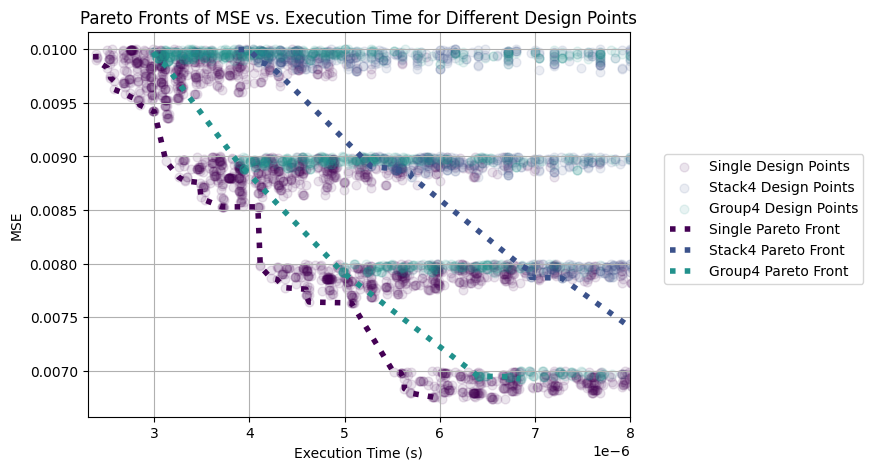

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming single_10GB, stack4_10GB, and group4_10GB are DataFrames with columns 'Execution Time (s)' and 'MSE'
# single_10GB = ...
# stack4_10GB = ...
# group4_10GB = ...

# Extract data for single_10GB
execution_time_single = single_10GB['Execution Time (s)'].values
mse_single = single_10GB['MSE'].values

# Extract data for stack4_10GB
execution_time_stack4 = stack4_10GB['Execution Time (s)'].values
mse_stack4 = stack4_10GB['MSE'].values

# Extract data for group4_10GB
execution_time_group4 = group4_10GB['Execution Time (s)'].values
mse_group4 = group4_10GB['MSE'].values

# Sort data based on execution time for single_10GB
sorted_indices_single = np.argsort(execution_time_single)
execution_time_single = execution_time_single[sorted_indices_single]
mse_single = mse_single[sorted_indices_single]

# Calculate Pareto front for single_10GB
pareto_front_single = []
min_mse_single = float('inf')
for et, mse_value in zip(execution_time_single, mse_single):
    if mse_value < min_mse_single:
        pareto_front_single.append((et, mse_value))
        min_mse_single = mse_value

pareto_front_single = np.array(pareto_front_single)

# Sort data based on execution time for stack4_10GB
sorted_indices_stack4 = np.argsort(execution_time_stack4)
execution_time_stack4 = execution_time_stack4[sorted_indices_stack4]
mse_stack4 = mse_stack4[sorted_indices_stack4]

# Calculate Pareto front for stack4_10GB
pareto_front_stack4 = []
min_mse_stack4 = float('inf')
for et, mse_value in zip(execution_time_stack4, mse_stack4):
    if mse_value < min_mse_stack4:
        pareto_front_stack4.append((et, mse_value))
        min_mse_stack4 = mse_value

pareto_front_stack4 = np.array(pareto_front_stack4)

# Sort data based on execution time for group4_10GB
sorted_indices_group4 = np.argsort(execution_time_group4)
execution_time_group4 = execution_time_group4[sorted_indices_group4]
mse_group4 = mse_group4[sorted_indices_group4]

# Calculate Pareto front for group4_10GB
pareto_front_group4 = []
min_mse_group4 = float('inf')
for et, mse_value in zip(execution_time_group4, mse_group4):
    if mse_value < min_mse_group4:
        pareto_front_group4.append((et, mse_value))
        min_mse_group4 = mse_value

pareto_front_group4 = np.array(pareto_front_group4)

# Plotting
plt.figure(figsize=(7, 5))
colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB['Execution Time (s)'], single_10GB['MSE'],
            color=colors[0], marker='o', s=40, label='Single Design Points', alpha=0.1)

plt.scatter(stack4_10GB['Execution Time (s)'], stack4_10GB['MSE'],
            color=colors[1], marker='o', s=40, label='Stack4 Design Points', alpha=0.1)

plt.scatter(group4_10GB['Execution Time (s)'], group4_10GB['MSE'],
            color=colors[2], marker='o', s=40, label='Group4 Design Points', alpha=0.1)

# Plot Pareto front for single_10GB
plt.plot(pareto_front_single[:, 0], pareto_front_single[:, 1], color=colors[0], linestyle='-', linewidth=4, label='Single Pareto Front')

# Plot Pareto front for stack4_10GB
plt.plot(pareto_front_stack4[:, 0], pareto_front_stack4[:, 1], color=colors[1], linestyle='-', linewidth=4, label='Stack4 Pareto Front')

# Plot Pareto front for group4_10GB
plt.plot(pareto_front_group4[:, 0], pareto_front_group4[:, 1], color=colors[2], linestyle='-', linewidth=4, label='Group4 Pareto Front')

plt.xlabel('Execution Time (s)')
plt.ylabel('MSE')
plt.xlim([0.0000023,0.000008])
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.title('Pareto Fronts of MSE vs. Execution Time for Different Design Points')
plt.grid(True)
plt.show()




In [ ]:
hybrid1_10GB

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,32,48,2,2,0.003000,24,16224.0,30816,1152,1.710480,5.350000,5.350000,0.000006
1,32,56,2,2,0.002964,22,16280.0,31064,1232,1.718902,5.042857,5.042857,0.000006
2,32,64,2,2,0.002976,20,16080.0,30800,1280,1.723366,4.812500,4.812500,0.000006
3,32,72,2,2,0.002949,19,16492.0,31692,1368,1.733319,4.633333,4.633333,0.000007
4,32,80,2,2,0.002958,18,16776.0,32328,1440,1.741060,4.490000,4.490000,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1,5,128,32,0.002940,16,18702.0,36928,80,1.801893,92.320000,18.018932,0.000002
724,1,6,128,32,0.002969,12,15562.5,30768,72,1.772912,85.466667,17.729119,0.000002
725,1,2,128,64,0.002931,20,20810.0,41040,40,1.815769,205.200000,18.157685,0.000002
726,1,3,128,64,0.002969,12,15558.0,30768,36,1.773372,170.933333,17.733718,0.000002


In [ ]:
hybrid3_10GB = design_space_exploration_hybrid(0.007, clock_frequency, bandwidth,3)

In [ ]:
hybrid3_10GB

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,32,48,2,2,0.003000,24,16224.0,30816,1152,1.710480,5.350000,5.350000,0.000006
1,32,56,2,2,0.002964,22,16280.0,31064,1232,1.718902,5.042857,5.042857,0.000006
2,32,64,2,2,0.002976,20,16080.0,30800,1280,1.723366,4.812500,4.812500,0.000006
3,32,72,2,2,0.002949,19,16492.0,31692,1368,1.733319,4.633333,4.633333,0.000007
4,32,80,2,2,0.002958,18,16776.0,32328,1440,1.741060,4.490000,4.490000,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1,5,128,32,0.002940,16,18702.0,36928,80,1.801893,92.320000,18.018932,0.000002
724,1,6,128,32,0.002969,12,15562.5,30768,72,1.772912,85.466667,17.729119,0.000002
725,1,2,128,64,0.002931,20,20810.0,41040,40,1.815769,205.200000,18.157685,0.000002
726,1,3,128,64,0.002969,12,15558.0,30768,36,1.773372,170.933333,17.733718,0.000002


In [78]:
baseline_10GB.to_csv('../dse_result4/baseline_10GB.csv', index=False)
single_10GB.to_csv('../dse_result4/single_10GB.csv', index=False)
stack4_10GB.to_csv('../dse_result4/stack4_10GB.csv', index=False)
group4_10GB.to_csv('../dse_result4/group4_10GB.csv', index=False)
# hybrid1_10GB.to_csv('../dse_result4/hybrid1_10GB.csv', index=False)
# hybrid3_10GB.to_csv('../dse_result4/hybrid3_10GB.csv', index=False)

In [40]:
def extract_result(name):

    # List to store all DataFrames
    dfs = []

    path = '/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/'

    # Loop through each file and load into a DataFrame
    for i in range(7):  # Assuming you have files named single_part_0.csv to single_part_6.csv
        filename = f"{path}{name}_part_{i}.csv"
        df = pd.read_csv(filename)
        dfs.append(df)

    # Concatenate all DataFrames into one
    combined_df = pd.concat(dfs, ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(f"{path}{name}_10GB.csv", index=False)

    return dfs

In [20]:
def update_results(df, clock_frequency, bandwidth, computation_roof):
    # Define a helper function to apply to each row
    def update_row(row):
        # Calculate CP (Clock Performance)
        row['CP (GOps/s)'] = (row['Nops'] / row['Ncycles']) * clock_frequency/1000
        
        # Calculate Attainable Performance (AttPerf)
        row['AttPerf (GOps/s)'] = min(row['CTC (Ops/byte)'] * bandwidth, row['CP (GOps/s)'],computation_roof)
        
        # Calculate Execution Time (Texe)
        if row['AttPerf (GOps/s)'] != 0:  # Avoid division by zero
            row['Execution Time (s)'] = row['Nops'] / row['AttPerf (GOps/s)']/1000000000
        else:
            row['Execution Time (s)'] = float('inf')  # Handle division by zero as infinite time
        
        return row

    # Apply the function across the DataFrame
    df = df.apply(update_row, axis=1)
    return df

In [111]:
def cal_dsp_usage_baseline(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr']) +
                           adder_dsp * (result['Tc'] - 1)*result['Tr'] +
                           multiplier_dsp * result['Tc'] *result['Tr']) * 4
    return result

In [19]:
def cal_dsp_usage(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 4

    return result

In [45]:
def cal_dsp_usage_stack4(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc'])

    return result

In [62]:
def remove(df, DSP_max):
    result = df.copy()

    result = result[result['DSP Usage'] < DSP_max]
    
    return result

In [52]:
import pandas as pd
from math import ceil, log2

def correct_baseline(df, clock_frequency, bandwidth, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    
    # If 'DSP Usage', 'Simulated Ncycles', 'Simulated Execution Time (s)' columns are not present, initialize them
    if 'DSP Usage' not in result:
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        result['Simulated Execution Time (s)'] = 0

    # Update the 'DSP Usage' with the specific formula
    result['DSP Usage'] = (accumulator_dsp * result['Tr'] +
                           adder_dsp * (result['Tc'] - 1) * result['Tr'] +
                           multiplier_dsp * result['Tc'] * result['Tr']) * 4
    
    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    condition = result['CP (GOps/s)'] == result['AttPerf (GOps/s)']
    result.loc[condition, 'Simulated Ncycles'] = (result['Ncycles'] + 3 + 
                                                  result['Tc'].apply(lambda x: ceil(log2(x))) + 
                                                  R / result['Tr'])
    result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
    
    # Handle cases where the condition is not met
    result.loc[~condition, 'Simulated Ncycles'] = 0
    result.loc[~condition, 'Simulated Execution Time (s)'] = 0

    return result
    

In [53]:
def correct_single(df, clock_frequency, bandwidth ,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # # Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    # result['Nops'] = (4*result['Nsteps']*(2*result['NZc']*result['Tc'] + 1 + 2*result['NZr']*result['Tr']))
    # # Compute the 'Ncycles' by using pandas methods that work with Series
    # # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    # term1 = result['Nsteps'] * result['NZr']
    # term2 = result['Nsteps'] * result['NZc']
    # # term3 = 7 * 64 / result['Tr']
    # result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    # inout = (C+2*R)*4
    # result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # # Compute 'CP (GOps/s)'
    # result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    # term1 = result['CP (GOps/s)']
    # term2 = result['CTC (Ops/byte)'] * bandwidth
    # result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    # result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']) * 4 

    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    condition = result['CP (GOps/s)'] == result['AttPerf (GOps/s)']
    result.loc[condition, 'Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] + R / result['Tr']
    result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
    
    # Handle cases where the condition is not met
    result.loc[~condition, 'Simulated Ncycles'] = 0
    result.loc[~condition, 'Simulated Execution Time (s)'] = 0


    return result

In [54]:
def correct_stack4(df, clock_frequency,bandwidth,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # N*(Nsteps*(2*NZc*Tc + 1 + 8*NZr*Tr) + 24*R)
    # result['Nops'] = (result['Nsteps']*(2*result['NZc']*result['Tc'] + 1 + 8*result['NZr']*result['Tr']))
    # # Compute the 'Ncycles' by using pandas methods that work with Series
    # # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    # term1 = 4 * result['Nsteps'] * result['NZr']
    # term2 = result['Nsteps'] * result['NZc']
    # # term3 = 7 * 64 / result['Tr']
    # result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    # inout = (C+2*R)*4
    # result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # # Compute 'CP (GOps/s)'
    # result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    # term1 = result['CP (GOps/s)']
    # term2 = result['CTC (Ops/byte)'] * bandwidth
    # result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    # result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) + 
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr'])

    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    condition = result['CP (GOps/s)'] == result['AttPerf (GOps/s)']
    result.loc[condition, 'Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] + 4*R / result['Tr']
    result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
    
    # Handle cases where the condition is not met
    result.loc[~condition, 'Simulated Ncycles'] = 0
    result.loc[~condition, 'Simulated Execution Time (s)'] = 0


    return result

In [55]:
def correct_group4(df, clock_frequency,bandwidth,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # # N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    # result['Nops'] = (result['Nsteps']*(8*result['NZc']*result['Tc'] + 4 + 8*result['NZr']*result['Tr']))
    # # Compute the 'Ncycles' by using pandas methods that work with Series
    # # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    # term1 = result['Nsteps'] * result['NZr']
    # term2 = result['Nsteps'] * result['NZc']
    # result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    # inout = (C+2*R)*4
    # result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # # Compute 'CP (GOps/s)'
    # result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    # term1 = result['CP (GOps/s)']
    # term2 = result['CTC (Ops/byte)'] * bandwidth
    # result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    # result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000

    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'])*4 +
                           adder_dsp * (result['Tc']) + multiplier_dsp * 4 + 
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']*4)

    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    condition = result['CP (GOps/s)'] == result['AttPerf (GOps/s)']
    result.loc[condition, 'Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] + 4*R / result['Tr']
    result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
    
    # Handle cases where the condition is not met
    result.loc[~condition, 'Simulated Ncycles'] = 0
    result.loc[~condition, 'Simulated Execution Time (s)'] = 0
        
    return result

In [57]:
def correct_hybrid(df, clock_frequency, bandwidth ,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    # result['Nops'] = (4*result['Nsteps']*(2*result['NZc']*result['Tc'] + 1 + 2*result['NZr']*result['Tr']))
    # # Compute the 'Ncycles' by using pandas methods that work with Series
    # # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    # term1 = result['Nsteps'] * result['NZr']
    # term2 = result['Nsteps'] * result['NZc']
    # # term3 = 7 * 64 / result['Tr']
    # result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)
    
    # inout = (C+2*R)*4
    # result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # # Compute 'CP (GOps/s)'
    # result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    # term1 = result['CP (GOps/s)']
    # term2 = result['CTC (Ops/byte)'] * bandwidth
    # result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    # result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0
        
    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']) * 4
    
    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    condition = result['CP (GOps/s)'] == result['AttPerf (GOps/s)']
    result.loc[condition, 'Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] + 4*R / result['Tr']
    result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
    
    # Handle cases where the condition is not met
    result.loc[~condition, 'Simulated Ncycles'] = 0
    result.loc[~condition, 'Simulated Execution Time (s)'] = 0
        
    return result

In [42]:
extract_result('single')
extract_result('stack4')
extract_result('group4')
extract_result('hybrid1')
extract_result('hybrid3')
extract_result('hybrid6')

In [214]:
single_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Single_10GB.csv')
stack4_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Stack4_10GB.csv')
group4_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Group4_10GB.csv')
hybrid1_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid1_10GB.csv')
hybrid3_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid3_10GB.csv')
# hybrid6_10GB = pd.read_csv('/Users/justin/Desktop/Year 4/FYP/Code/main/dse_result1/Hybrid6_10GB.csv')

In [92]:
baseline_10GB_dsp = correct_baseline(baseline_10GB,clock_frequency,bandwidth,1,4,1)
single_10GB_dsp = correct_single(single_10GB,clock_frequency,bandwidth,1,4,1)
stack4_10GB_dsp = correct_stack4(stack4_10GB,clock_frequency,bandwidth,1,4,1)
group4_10GB_dsp = correct_group4(group4_10GB,clock_frequency,bandwidth,1,4,1)
# hybrid1_10GB_dsp = correct_hybrid(hybrid1_10GB,clock_frequency,bandwidth,1,4,1)
# hybrid3_10GB_dsp = correct_hybrid(hybrid3_10GB,clock_frequency,bandwidth,1,4,1)
# hybrid6_10GB_dsp = cal_dsp_usage(hybrid6_10GB, 2, 2, 7)

# remove entries that do not satisfy accuracy requirement
single_10GB_dsp = remove(single_10GB_dsp, 150)
stack4_10GB_dsp = remove(stack4_10GB_dsp, 150)
group4_10GB_dsp = remove(group4_10GB_dsp, 150)
# hybrid1_10GB_dsp = remove(hybrid1_10GB_dsp, 1000)
# hybrid3_10GB_dsp = remove(hybrid3_10GB_dsp, 1000)
# hybrid6_10GB_dsp = remove(hybrid6_10GB_dsp, accuracy_baseline,3.3484)

baseline_10GB_dsp.to_csv('../dse_result3/baseline_10GB_dsp.csv', index=False)
single_10GB_dsp.to_csv('../dse_result3/single_10GB_dsp.csv', index=False)
stack4_10GB_dsp.to_csv('../dse_result3/stack4_10GB_dsp.csv', index=False)
group4_10GB_dsp.to_csv('../dse_result3/group4_10GB_dsp.csv', index=False)
# hybrid1_10GB_dsp.to_csv('../dse_result3/hybrid1_10GB_dsp.csv', index=False)
# hybrid3_10GB_dsp.to_csv('../dse_result3/hybrid3_10GB_dsp.csv', index=False)
# hybrid6_10GB_dsp.to_csv('../dse_result1/hybrid6_10GB_dsp.csv', index=False)

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_98521/299850991.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.0650e-06 7.3800e-06 8.0600e-06 8.7400e-06 6.7650e-06 7.3250e-06
 8.2850e-06 8.7600e-06 9.1550e-06 9.9550e-06 7.8400e-06 8.5200e-06
 9.2600e-06 9.8550e-06 1.0370e-05 1.1290e-05 8.6000e-06 9.3600e-06
 7.9150e-06 9.5650e-06 1.0200e-05 1.1200e-05 1.1715e-05 8.5850e-06
 8.9800e-06 9.7800e-06 8.3300e-06 9.4700e-06 9.9000e-06 1.0575e-05
 1.1615e-05 1.2655e-05 8.2950e-06 9.8850e-06 1.0560e-05 1.1155e-05
 1.2155e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[condition, 'Simulated Execution Time (s)'] = result['Simulated Ncycles'] / (clock_frequency * 1000000)
/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_98521/932732279.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an err

In [65]:
baseline_10GB_dsp


,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s)
0,2,2,0,N/A,393216,196096,6144.0,0.496436,6.383333,4.964355,0.00004,80,0,0
1,2,4,0,N/A,393216,196096,3072.0,0.496436,12.766667,4.964355,0.00004,160,0,0
2,2,8,0,N/A,393216,196096,1536.0,0.496436,25.533333,4.964355,0.00004,320,0,0
3,2,16,0,N/A,393216,196096,768.0,0.496436,51.066667,4.964355,0.00004,640,0,0
4,2,32,0,N/A,393216,196096,384.0,0.496436,102.133333,4.964355,0.00004,1280,0,0
5,2,64,0,N/A,393216,196096,192.0,0.496436,204.266667,4.964355,0.00004,2560,0,0
6,4,2,0,N/A,393216,196096,3072.0,0.496436,12.766667,4.964355,0.00004,160,0,0
7,4,4,0,N/A,393216,196096,1536.0,0.496436,25.533333,4.964355,0.00004,320,0,0
8,4,8,0,N/A,393216,196096,768.0,0.496436,51.066667,4.964355,0.00004,640,0,0
9,4,16,0,N/A,393216,196096,384.0,0.496436,102.133333,4.964355,0.00004,1280,0,0


In [66]:
single_10GB_dsp


,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s)
0,32,48,2,2,0.004951,42,111552.0,53760,2016,0.474308,5.333333,4.743083,0.000011,80,0,0.000000
1,32,56,2,2,0.004911,38,110656.0,53504,2128,0.475811,5.028571,4.758110,0.000011,80,0,0.000000
2,32,64,2,2,0.004986,34,107712.0,52224,2176,0.476914,4.800000,4.769141,0.000011,80,0,0.000000
3,32,72,2,2,0.004946,32,109568.0,53248,2304,0.478161,4.622222,4.622222,0.000012,80,2435,0.000012
4,32,80,2,2,0.004975,30,110400.0,53760,2400,0.479179,4.480000,4.480000,0.000012,80,2529,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,2,8,64,16,0.004991,31,127689.0,63488,248,0.490327,51.200000,4.903268,0.000013,1600,0,0.000000
665,2,9,64,16,0.004933,28,122500.0,60928,252,0.490200,48.355556,4.902005,0.000012,1600,0,0.000000
666,2,10,64,16,0.004876,25,115775.0,57600,250,0.489933,46.080000,4.899334,0.000012,1600,0,0.000000
667,2,11,64,16,0.004902,22,107514.0,53504,242,0.489488,44.218182,4.894882,0.000011,1600,0,0.000000


In [67]:
stack4_10GB_dsp


,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s)
0,32,48,2,2,0.007465,46,66976.00,32384,5888,0.470917,1.10,1.100000,0.000029,20,2545,0.000013
1,32,56,2,2,0.007099,46,69920.00,33856,5888,0.472111,1.15,1.150000,0.000029,20,2913,0.000015
2,32,64,2,2,0.006841,46,72864.00,35328,5888,0.473210,1.20,1.200000,0.000029,20,3281,0.000016
3,32,72,2,2,0.006628,46,75808.00,36800,5888,0.474227,1.25,1.250000,0.000029,20,3649,0.000018
4,32,80,2,2,0.006484,46,78752.00,38272,5888,0.475169,1.30,1.300000,0.000029,20,4017,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,2,4,64,32,0.006787,46,118024.50,58880,368,0.491418,32.00,4.914181,0.000012,480,0,0.000000
671,2,5,64,32,0.005873,46,123912.50,61824,368,0.491820,33.60,4.918201,0.000013,480,0,0.000000
672,2,6,64,32,0.005093,46,129800.50,64768,368,0.492186,35.20,4.921861,0.000013,480,0,0.000000
673,2,2,64,64,0.006842,46,118007.25,58880,368,0.491489,32.00,4.914889,0.000012,640,0,0.000000


In [82]:
group4_10GB_dsp

,NZr,NZc,Tr,Tc,MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Execution Time (s),Simulated Ncycles
0,32,48,2,2,0.007621,81,54756.000,104004,3888,1.839216,5.350000,5.350000,0.000019,66,0.000021,4260.0
1,32,56,2,2,0.007269,81,59940.000,114372,4536,1.852718,5.042857,5.042857,0.000023,66,0.000025,4908.0
2,32,64,2,2,0.006997,80,64320.000,123200,5120,1.863504,4.812500,4.812500,0.000026,66,0.000027,5491.0
3,32,72,2,2,0.006988,75,65100.000,125100,5400,1.870179,4.633333,4.633333,0.000027,66,0.000029,5766.0
4,32,80,2,2,0.006985,73,68036.000,131108,5840,1.877585,4.490000,4.490000,0.000029,66,0.000031,6204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,2,4,64,32,0.006989,78,81198.000,160056,312,1.928618,102.600000,19.286179,0.000008,1456,0.000000,0.0
671,2,5,64,32,0.006992,59,68971.000,136172,295,1.924339,92.320000,19.243390,0.000007,1456,0.000000,0.0
672,2,6,64,32,0.006996,49,63553.000,125636,294,1.922657,85.466667,19.226567,0.000007,1456,0.000000,0.0
673,2,2,64,64,0.006968,80,83250.000,164160,160,1.930340,205.200000,19.303403,0.000009,1616,0.000000,0.0


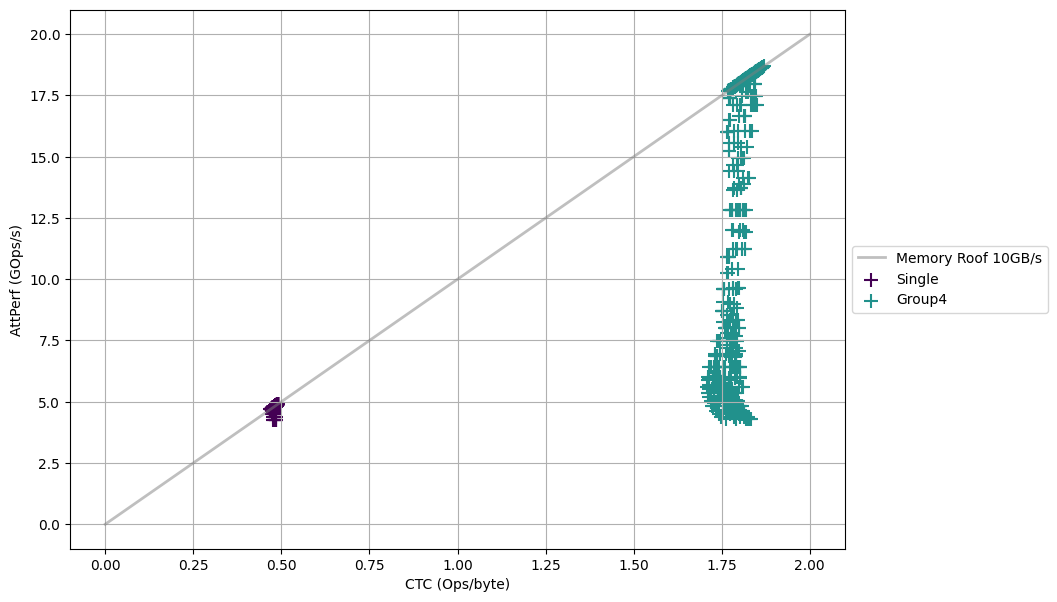

In [59]:
# Plotting
plt.figure(figsize=(10, 7))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.5, linewidth=2)

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

# plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
#             color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
# plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
#             color=colors[3], marker='+', s=100, label='Hybrid1')

# plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
#             color=colors[4], marker='+', s=100, label='Hybrid3')

# plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
#             color='red', marker='+', s=100, label='Baseline')


# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.xlim([0.45,2])
# plt.ylim([4.5,20])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

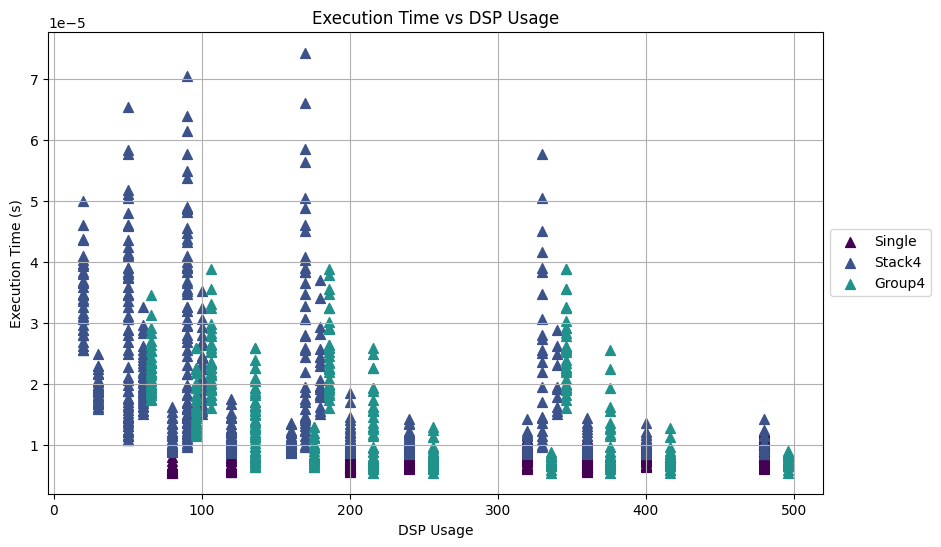

In [84]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['Execution Time (s)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=50, label='Group4')
            
# plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['Execution Time (s)'],
#             color=colors[3], marker='^', s=50, label='Hybrid1')

# plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['Execution Time (s)'],
#             color=colors[4], marker='^', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

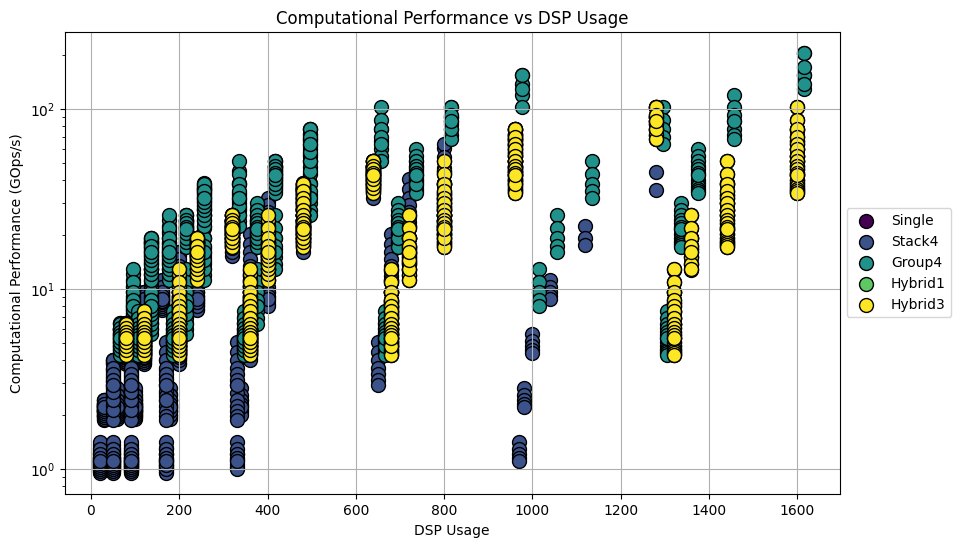

In [63]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['CP (GOps/s)'],
            color=colors[0], marker='o',edgecolors='black', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['CP (GOps/s)'],
            color=colors[1], marker='o',edgecolors='black', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['CP (GOps/s)'],
            color=colors[2], marker='o',edgecolors='black', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['CP (GOps/s)'],
            color=colors[3], marker='o',edgecolors='black', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['CP (GOps/s)'],
            color=colors[4], marker='o',edgecolors='black', s=100, label='Hybrid3')
            

# Labeling the axes
plt.title('Computational Performance vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Computational Performance (GOps/s)')

# Set y-axis to log scale
plt.yscale('log')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

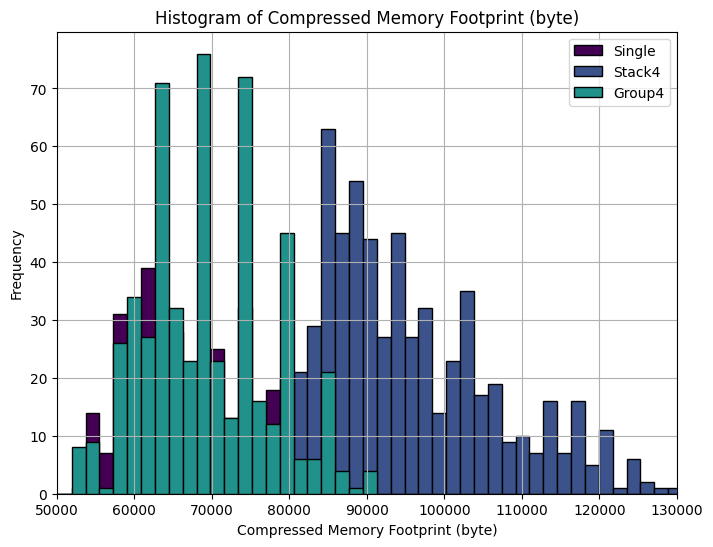

In [88]:
# Plotting the histogram
plt.figure(figsize=(8, 6))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    stack4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    group4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 80  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')

# Adding labels and title
plt.xlabel('Compressed Memory Footprint (byte)')
plt.ylabel('Frequency')
plt.title('Histogram of Compressed Memory Footprint (byte)')

# Show the grid
plt.grid(True)
plt.xlim([50000,130000])

plt.legend()
# Display the plot
plt.show()

In [75]:
print(f"Single Nops Median: {single_10GB_dsp['Nops'].median()}")
print(f"Stack4 Nops Median: {stack4_10GB_dsp['Nops'].median()}")
print(f"Group4 Nops Median: {group4_10GB_dsp['Nops'].median()}")
print(f"Hybrid1 Nops Median: {hybrid1_10GB_dsp['Nops'].median()}")
print(f"Hybrid3 Nops Median: {hybrid3_10GB_dsp['Nops'].median()}")

Single Nops Median: 30008.0
Stack4 Nops Median: 27897.0
Group4 Nops Median: 107240.0
Hybrid1 Nops Median: 77428.0
Hybrid3 Nops Median: 47972.0


In [76]:
print(f"Single AttPerf (GOps/s) Median: {single_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Stack4 AttPerf (GOps/s) Median: {stack4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Group4 AttPerf (GOps/s) Median: {group4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid1 AttPerf (GOps/s) Median: {hybrid1_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid3 AttPerf (GOps/s) Median: {hybrid3_10GB_dsp['AttPerf (GOps/s)'].median()}")

Single AttPerf (GOps/s) Median: 5.337003222341568
Stack4 AttPerf (GOps/s) Median: 5.275166052759603
Group4 AttPerf (GOps/s) Median: 19.53715314986662
Hybrid1 AttPerf (GOps/s) Median: 14.198049272663399
Hybrid3 AttPerf (GOps/s) Median: 8.067908397226681


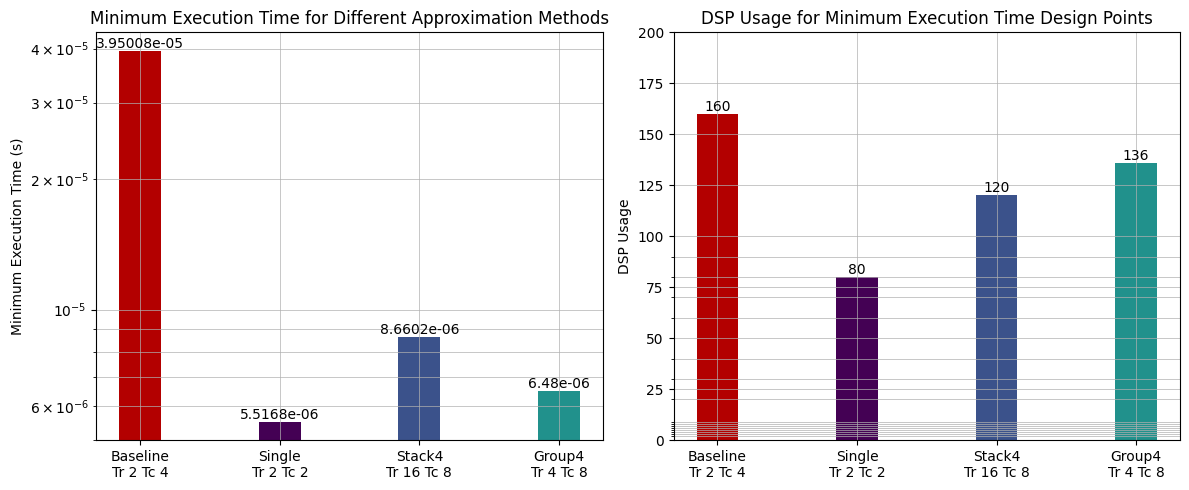

In [95]:
import matplotlib.ticker as ticker

baseline_10GB_min = baseline_10GB_dsp[baseline_10GB_dsp['Execution Time (s)'] == baseline_10GB_dsp['Execution Time (s)'].min()].iloc[1]
single_10GB_min = single_10GB_dsp[single_10GB_dsp['Execution Time (s)'] == single_10GB_dsp['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10GB_dsp[stack4_10GB_dsp['Execution Time (s)'] == stack4_10GB_dsp['Execution Time (s)'].min()]
group4_10GB_min = group4_10GB_dsp[group4_10GB_dsp['Execution Time (s)'] == group4_10GB_dsp['Execution Time (s)'].min()]
# hybrid1_10GB_min = hybrid1_10GB_dsp[hybrid1_10GB_dsp['Execution Time (s)'] == hybrid1_10GB_dsp['Execution Time (s)'].min()]
# hybrid3_10GB_min = hybrid3_10GB_dsp[hybrid3_10GB_dsp['Execution Time (s)'] == hybrid3_10GB_dsp['Execution Time (s)'].min()]

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        # f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        # f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0]
        # hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        # hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}"
        # f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        # f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0]
        # hybrid1_10GB_min['DSP Usage'].iloc[0],
        # hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(12, 5))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
# plt.yscale('log')

# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.ylim([0,200])

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [160]:
baseline_10GB_min= baseline_10GB_dsp.nsmallest(50, 'Execution Time (s)').iloc[0]
single_10GB_min_5 = single_10GB_dsp.nsmallest(50, 'Execution Time (s)')
stack4_10GB_min_5 = stack4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
group4_10GB_min_5 = group4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid1_10GB_min_5 = hybrid1_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid3_10GB_min_5 = hybrid3_10GB_dsp.nsmallest(50, 'Execution Time (s)')

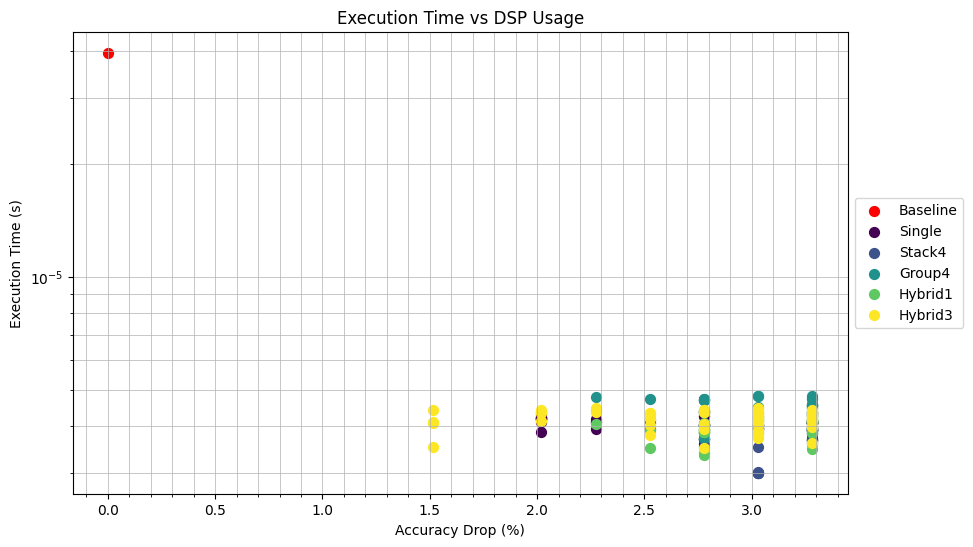

In [161]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(accuracy_baseline*100 - baseline_10GB_min['Accuracy (%)'], baseline_10GB_min['Execution Time (s)'],
            color='red', marker='o', s=50, label='Baseline')

plt.scatter(accuracy_baseline*100 - single_10GB_min_5['Accuracy (%)'], single_10GB_min_5['Execution Time (s)'],
            color=colors[0], marker='o', s=50, label='Single')

plt.scatter(accuracy_baseline*100 - stack4_10GB_min_5['Accuracy (%)'], stack4_10GB_min_5['Execution Time (s)'],
            color=colors[1], marker='o', s=50, label='Stack4')

plt.scatter(accuracy_baseline*100 - group4_10GB_min_5['Accuracy (%)'], group4_10GB_min_5['Execution Time (s)'],
            color=colors[2], marker='o', s=50, label='Group4')
            
plt.scatter(accuracy_baseline*100 - hybrid1_10GB_min_5['Accuracy (%)'], hybrid1_10GB_min_5['Execution Time (s)'],
            color=colors[3], marker='o', s=50, label='Hybrid1')

plt.scatter(accuracy_baseline*100 - hybrid3_10GB_min_5['Accuracy (%)'], hybrid3_10GB_min_5['Execution Time (s)'],
            color=colors[4], marker='o', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('Accuracy Drop (%)')
plt.ylabel('Execution Time (s)')
# Setting y-axis to logarithmic scale
plt.yscale('log')

# Setting minor locators for the y-axis
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))

# Setting minor locators for the x-axis
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Automatically determine the number of minor intervals

# Enabling grid for both major and minor ticks
plt.grid(True, which="both", linestyle='-', linewidth=0.5, axis='both')  # Enable grid on both axes

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [134]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
baseline_5GB = update_results(baseline_10GB_dsp,400,5,20)
single_5GB = update_results(single_10GB_dsp,400,5,20)
stack4_5GB = update_results(stack4_10GB_dsp,400,5,20)
group4_5GB = update_results(group4_10GB_dsp,400,5,20)
hybrid1_5GB = update_results(hybrid1_10GB_dsp,400,5,20)
hybrid3_5GB = update_results(hybrid3_10GB_dsp,400,5,20)

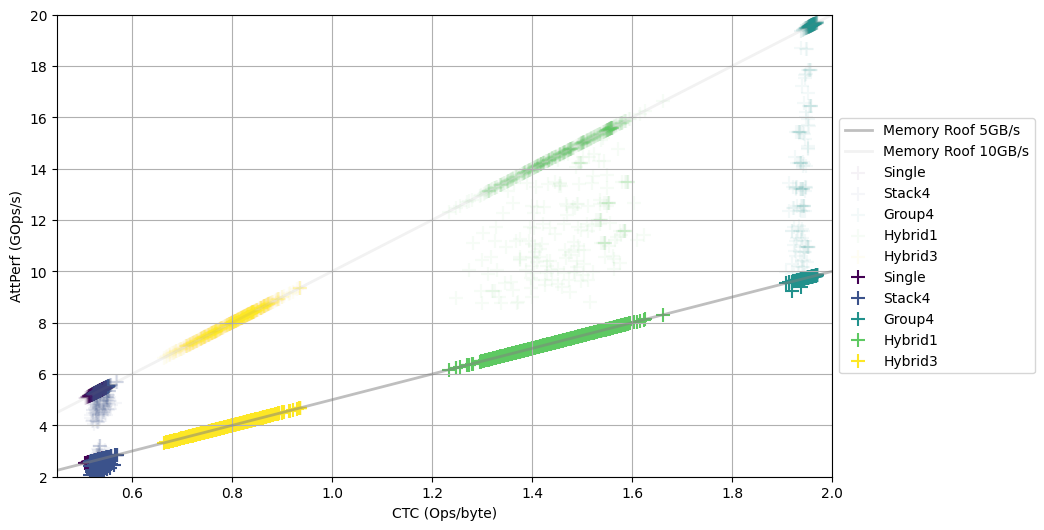

In [80]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 5 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 5GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_5GB['CTC (Ops/byte)'], single_5GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_5GB['CTC (Ops/byte)'], stack4_5GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_5GB['CTC (Ops/byte)'], group4_5GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_5GB['CTC (Ops/byte)'], hybrid1_5GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_5GB['CTC (Ops/byte)'], hybrid3_5GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.ylim([2,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

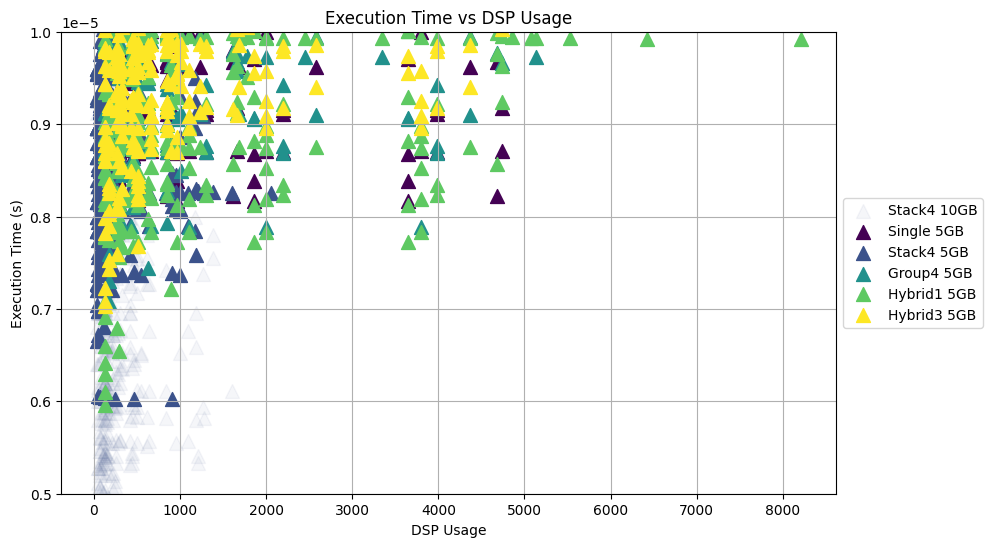

In [88]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_5GB['DSP Usage'], single_5GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_5GB['DSP Usage'], stack4_5GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_5GB['DSP Usage'], group4_5GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_5GB['DSP Usage'], hybrid1_5GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_5GB['DSP Usage'], hybrid3_5GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.ylim([0.000005,0.00001])

# Show the plot
plt.show()

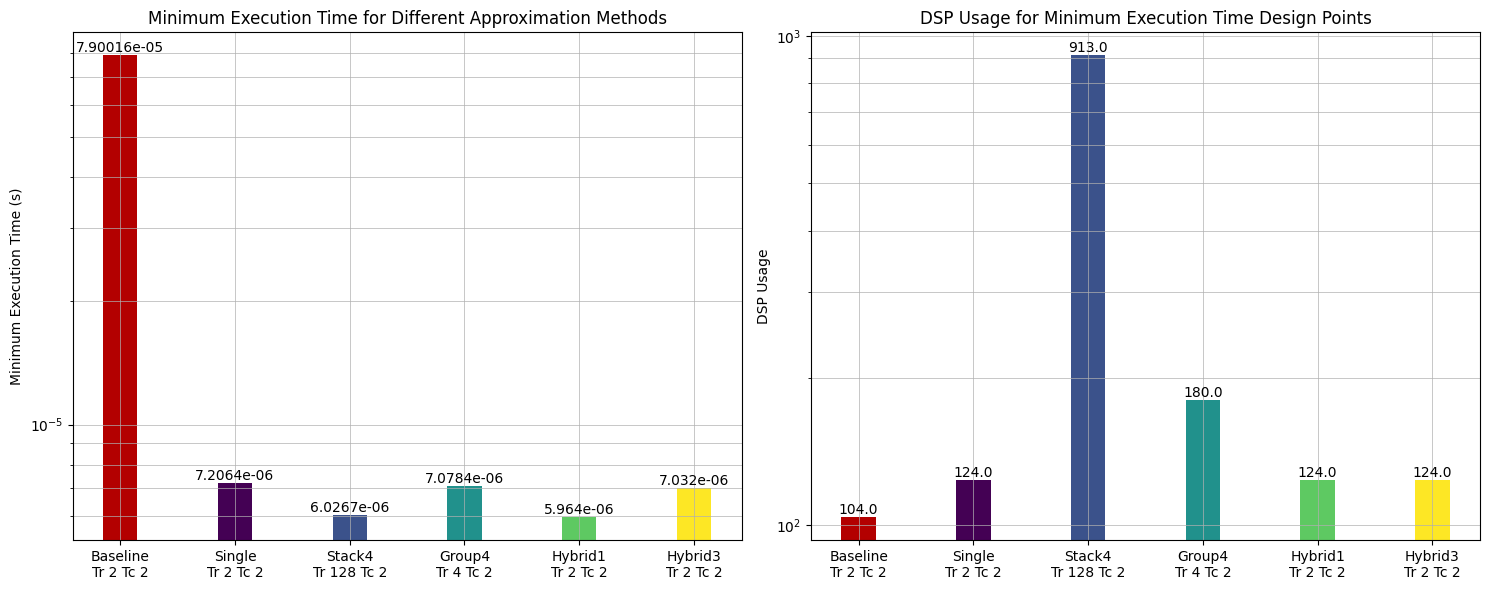

In [136]:
import matplotlib.ticker as ticker

baseline_10GB_min = baseline_5GB[baseline_5GB['Execution Time (s)'] == baseline_5GB['Execution Time (s)'].min()].iloc[0]
single_10GB_min = single_5GB[single_5GB['Execution Time (s)'] == single_5GB['Execution Time (s)'].min()]
stack4_10GB_min = stack4_5GB[stack4_5GB['Execution Time (s)'] == stack4_5GB['Execution Time (s)'].min()]
group4_10GB_min = group4_5GB[group4_5GB['Execution Time (s)'] == group4_5GB['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_5GB[hybrid1_5GB['Execution Time (s)'] == hybrid1_5GB['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_5GB[hybrid3_5GB['Execution Time (s)'] == hybrid3_5GB['Execution Time (s)'].min()]

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {int(baseline_10GB_min['Tr'])} Tc {int(baseline_10GB_min['Tc'])}",
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {int(baseline_10GB_min['Tr'])} Tc {int(baseline_10GB_min['Tc'])}",
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0],
        hybrid1_10GB_min['DSP Usage'].iloc[0],
        hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(15, 6))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
plt.yscale('log')
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [89]:
single_20GB = update_results(single_10GB_dsp,400,20,50)
stack4_20GB = update_results(stack4_10GB_dsp,400,20,50)
group4_20GB = update_results(group4_10GB_dsp,400,20,50)
hybrid1_20GB = update_results(hybrid1_10GB_dsp,400,20,50)
hybrid3_20GB = update_results(hybrid3_10GB_dsp,400,20,50)

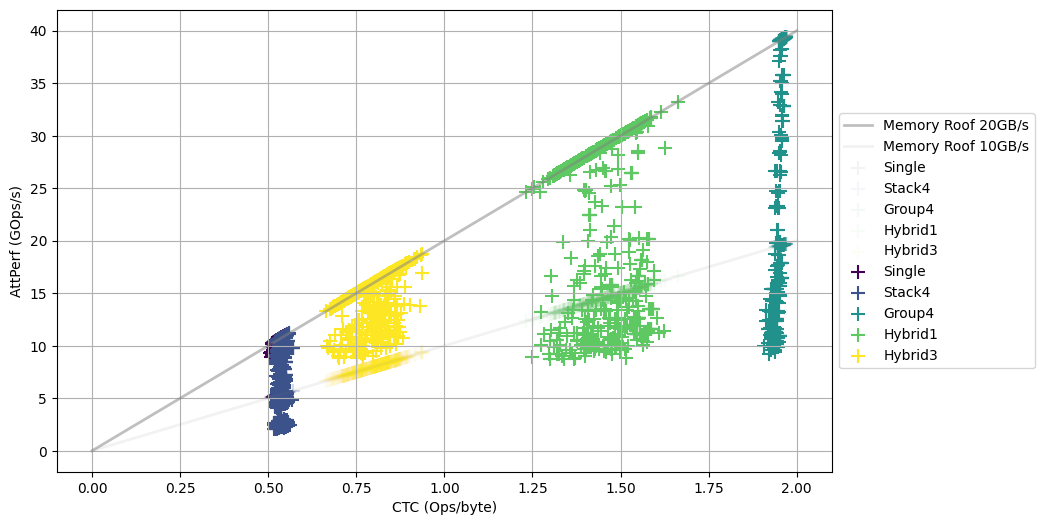

In [92]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 20 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 20GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_20GB['CTC (Ops/byte)'], single_20GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_20GB['CTC (Ops/byte)'], stack4_20GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_20GB['CTC (Ops/byte)'], group4_20GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_20GB['CTC (Ops/byte)'], hybrid1_20GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_20GB['CTC (Ops/byte)'], hybrid3_20GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
# plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

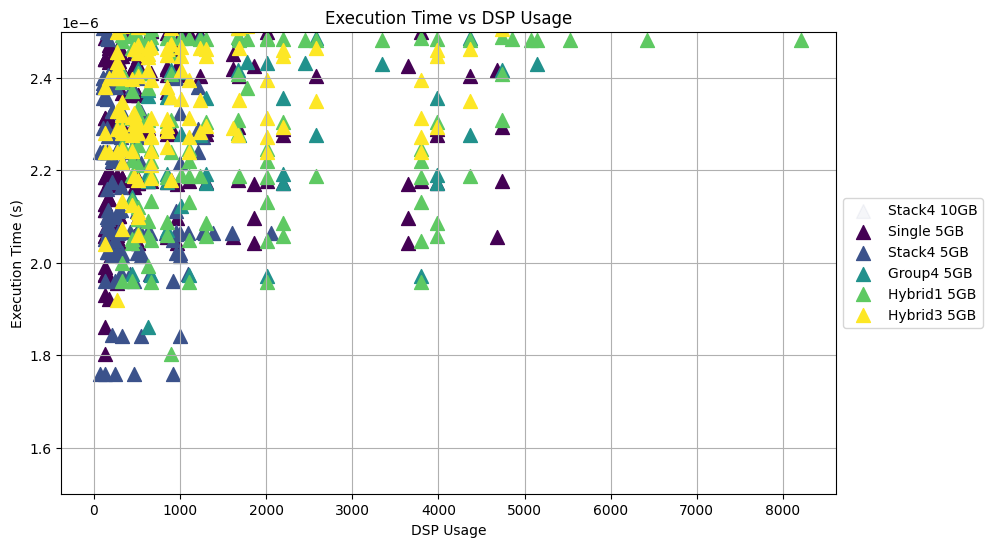

In [98]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_20GB['DSP Usage'], single_20GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_20GB['DSP Usage'], stack4_20GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_20GB['DSP Usage'], group4_20GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_20GB['DSP Usage'], hybrid1_20GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_20GB['DSP Usage'], hybrid3_20GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.ylim([0.0000015,0.0000025])

# Show the plot
plt.show()

In [106]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_40GB = update_results(single_10GB_dsp,400,40,100)
stack4_40GB = update_results(stack4_10GB_dsp,400,40,100)
group4_40GB = update_results(group4_10GB_dsp,400,40,100)
hybrid1_40GB = update_results(hybrid1_10GB_dsp,400,40,100)
hybrid3_40GB = update_results(hybrid3_10GB_dsp,400,40,100)

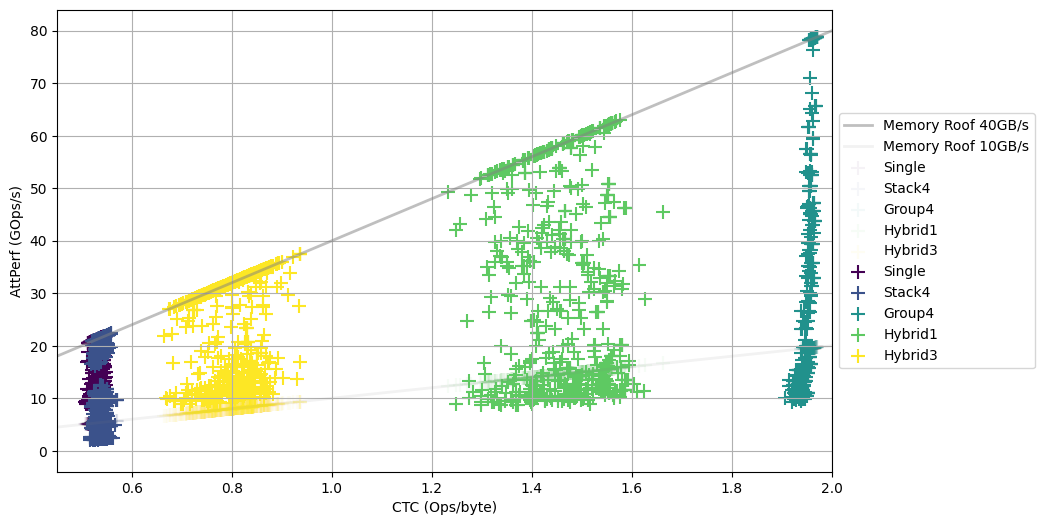

In [108]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 40 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 40GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_40GB['CTC (Ops/byte)'], single_40GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_40GB['CTC (Ops/byte)'], stack4_40GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_40GB['CTC (Ops/byte)'], group4_40GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_40GB['CTC (Ops/byte)'], hybrid1_40GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_40GB['CTC (Ops/byte)'], hybrid3_40GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

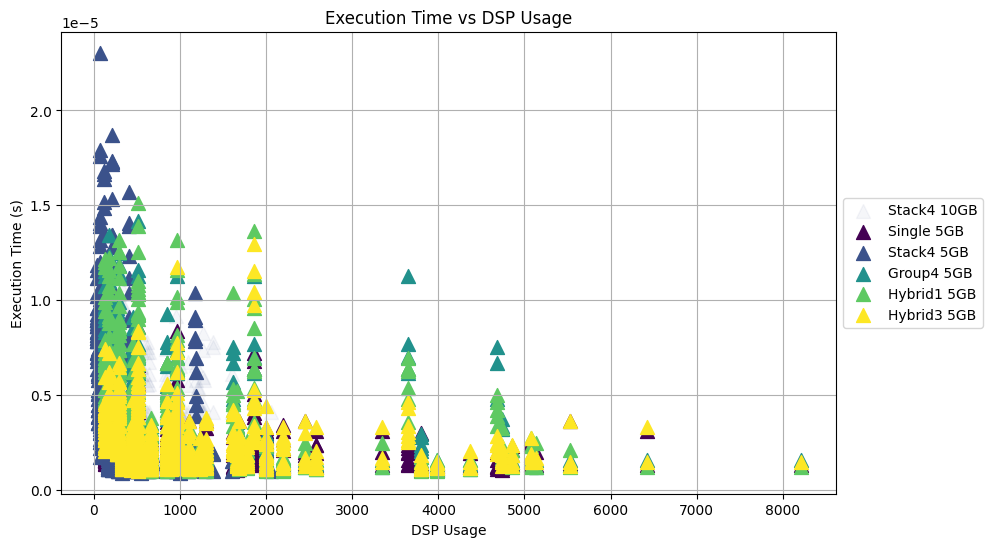

In [109]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.05)

plt.scatter(single_40GB['DSP Usage'], single_40GB['Execution Time (s)'],
            color=colors[0], marker='^', s=100, label='Single 5GB')
plt.scatter(stack4_40GB['DSP Usage'], stack4_40GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')
plt.scatter(group4_40GB['DSP Usage'], group4_40GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')
plt.scatter(hybrid1_40GB['DSP Usage'], hybrid1_40GB['Execution Time (s)'],
            color=colors[3], marker='^', s=100, label='Hybrid1 5GB')
plt.scatter(hybrid3_40GB['DSP Usage'], hybrid3_40GB['Execution Time (s)'],
            color=colors[4], marker='^', s=100, label='Hybrid3 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()